Interpretable Machine Learning Models of Chemometric Trends in Seabirds of the North Pacific Ocean
===

Author: Nathan A. Mahynski

Date: 2023/09/27

Description: Identifying chemometric trends in seabird eggs using interpretable machine learning models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/applications/2023_stamp.ipynb)

This is based on [Mahynski, N.A., Ragland, J.M., Schuur, S.S. et al. Building Interpretable Machine Learning Models to Identify Chemometric Trends in Seabirds of the North Pacific Ocean. Env. Sci. & Tech. 56, 14361–14374 (2022). https://doi.org/10.1021/acs.est.2c01894](https://doi.org/10.1021/acs.est.2c01894)

~~~code
@article{mahynski2022building,
  title={Building Interpretable Machine Learning Models to Identify Chemometric Trends in Seabirds of the North Pacific Ocean},
  author={Mahynski, Nathan A and Ragland, Jared M and Schuur, Stacy S and Shen, Vincent K},
  journal={Environmental Science \& Technology},
  volume={56},
  number={20},
  pages={14361--14374},
  year={2022},
  publisher={ACS Publications}
}
~~~

Also see the associated [GitHub repository](https://github.com/mahynski/stamp-dataset-1999-2010).

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [2]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [39]:
import imblearn

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

from mpl_toolkits.mplot3d import Axes3D

from pychemauth.datasets import load_stamp2010
from pychemauth.preprocessing.imbalanced import ScaledSMOTEENN

In [5]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-33-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

json      : 2.0.9
pychemauth: 0.0.0b3
watermark : 2.4.3
matplotlib: 3.7.2



<h3>Load the Data</h3>

In [6]:
# You will need an active internet connection - this function loads the data directly from the GitHub repo above.
data_bunch = load_stamp2010()

In [7]:
data_bunch.keys()

dict_keys(['data', 'target', 'feature_names', 'target_names', 'frame', 'DESCR'])

In [8]:
data_bunch['DESCR']

"Dataset reported in Schuur, Stacy S., Ragland, Jared M., Mahynski, Nathan A. (2021), Data Supporting 'Seabird Tissue Archival and Monitoring Project (STAMP) Data from 1999-2010', National Institute of Standards and Technology, https://doi.org/10.18434/mds2-2431 . See this publication for a full description."

In [36]:
title_size, label_size, tick_size = 16, 14, 12

Model Genus
---

<h3>Label the Data</h3>

In [60]:
X = pd.DataFrame(data=data_bunch['data'], columns=data_bunch['feature_names'], dtype=np.float64)
y = pd.DataFrame(data=data_bunch['target'][:,2], columns=['Common Name'])

def genus(name):
    if ('gull' in name):
        return r'${\it Larus}$ (gull)'
    elif ('murre' in name):
        return r'${\it Uria}$ (murre)'
    elif ('albatross' in name):
        return r'${\it Phoebastria}$ (albatross)'
    else:
        raise Exception('unexpected value')
        
y = y['Common Name'].apply(genus)

<h3>Examine the Class Imbalance</h3>

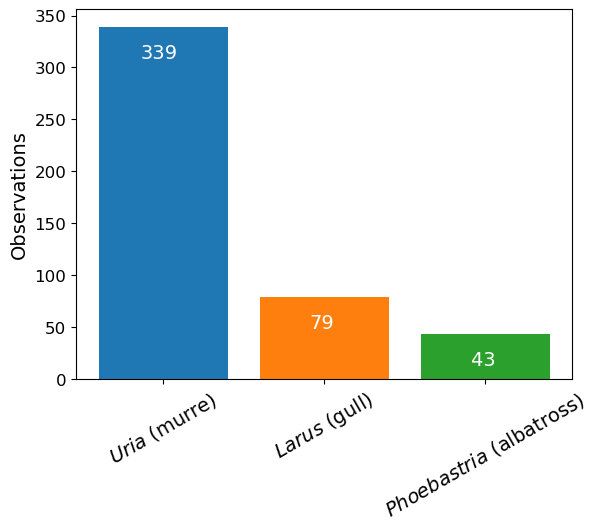

In [61]:
plt.bar(
    x=y.unique(),
    height=[np.sum(y==c) for c in y.unique()],
    color=['C0', 'C1', 'C2'],
)
plt.ylabel('Observations', fontsize=label_size)
_ = plt.xticks(rotation=30, fontsize=label_size)
_ = plt.yticks(fontsize=tick_size)

for i,c in enumerate(y.unique()):
    if (i == 0):
        shift = .1+0.04
    else:
        shift= .05+0.04
    plt.text(i-shift,np.sum(y==c)-30, str(np.sum(y==c)), color='white', fontsize=label_size)
# plt.savefig('genus_count.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


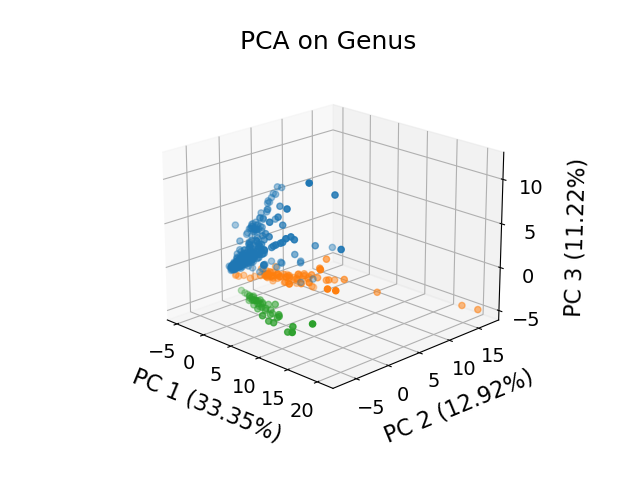

In [62]:
%matplotlib notebook

pca = PCA(n_components=3)
ss = StandardScaler()
X_proj = pca.fit_transform(ss.fit_transform(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for bird in y.unique():
    mask = y == bird 
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=bird)
# ax.legend(loc='best')
ax.set_xlabel('PC 1 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[0]*100)), 
              fontsize=label_size+2, labelpad=10)
ax.set_ylabel('PC 2 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[1]*100))
              , fontsize=label_size+2, labelpad=10)
ax.set_zlabel('PC 3 ({}%)'.format('%.2f'%(pca.explained_variance_ratio_[2]*100))
              , fontsize=label_size+2, labelpad=10)
ax.set_title('PCA on Genus', fontsize=title_size+2)
ax.view_init(elev=20., azim=-45)

ax.tick_params(axis='x', which='major', labelsize=12+2)
ax.tick_params(axis='y', which='major', labelsize=12+2)
ax.tick_params(axis='z', which='major', labelsize=12+2)

# plt.savefig('genus_pca.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


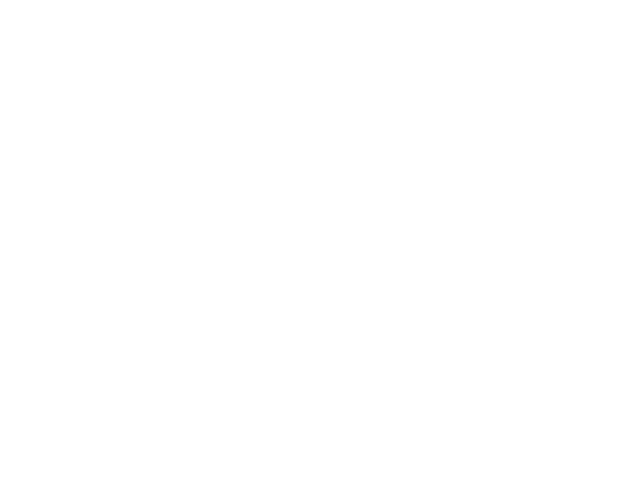

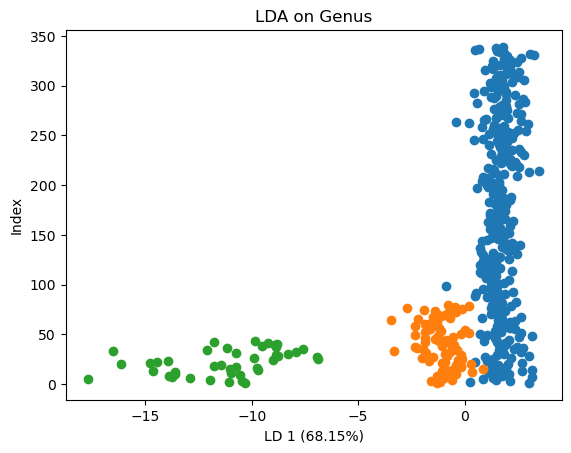

In [63]:
%matplotlib inline

lda = LDA(n_components=1, store_covariance=True)
ss = StandardScaler()
X_proj = lda.fit_transform(ss.fit_transform(X), y)

fig, ax = plt.subplots()

for bird in y.unique():
    mask = y == bird
    ax.plot(X_proj[mask,0], np.arange(1,1+X_proj[mask].shape[0]), 'o', 
             label=bird)
plt.xlabel('LD 1 ({}%)'.format('%.2f'%(lda.explained_variance_ratio_[0]*100)))
#            , fontsize=label_size+2)
plt.ylabel('Index')#, fontsize=label_size+2)
plt.title('LDA on Genus')#, fontsize=title_size+2)
plt.tick_params(axis='x', which='major')#, labelsize=tick_size+2)
plt.tick_params(axis='y', which='major')#, labelsize=tick_size+2)

<h3>Try Some Decision Trees</h3>

In [65]:
# KFold CV on entire dataset to build production model

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("smote", ScaledSMOTEENN(random_state=1)),
    ('tree', DecisionTreeClassifier(random_state=1))
])

param_grid = [
    {
     'smote__k_enn':[3, 5, 7, 10],
     'smote__k_smote':[3, 5, 7, 10],
     'smote__kind_sel_enn':['all', 'mode'],
     'tree__max_depth':np.arange(1,4+1),
    }]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  n_jobs=-1,
                  refit=True, # Refit on all the data
                  cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True))

gs.fit(X.values, y.values)

/home/nam4/anaconda3/envs/oyster-provenance/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam4/anaconda3/envs/oyster-provenance/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam4/anaconda3/envs/oyster-provenance/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nam4/anaconda

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('smote',
                                        <pychemauth.preprocessing.imbalanced.ScaledSMOTEENN object at 0x7f22a8803d50>),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'smote__k_enn': [3, 5, 7, 10],
                          'smote__k_smote': [3, 5, 7, 10],
                          'smote__kind_sel_enn': ['all', 'mode'],
                          'tree__max_depth': array([1, 2, 3, 4])}])

In [66]:
gs.best_params_

{'smote__k_enn': 3,
 'smote__k_smote': 5,
 'smote__kind_sel_enn': 'all',
 'tree__max_depth': 3}

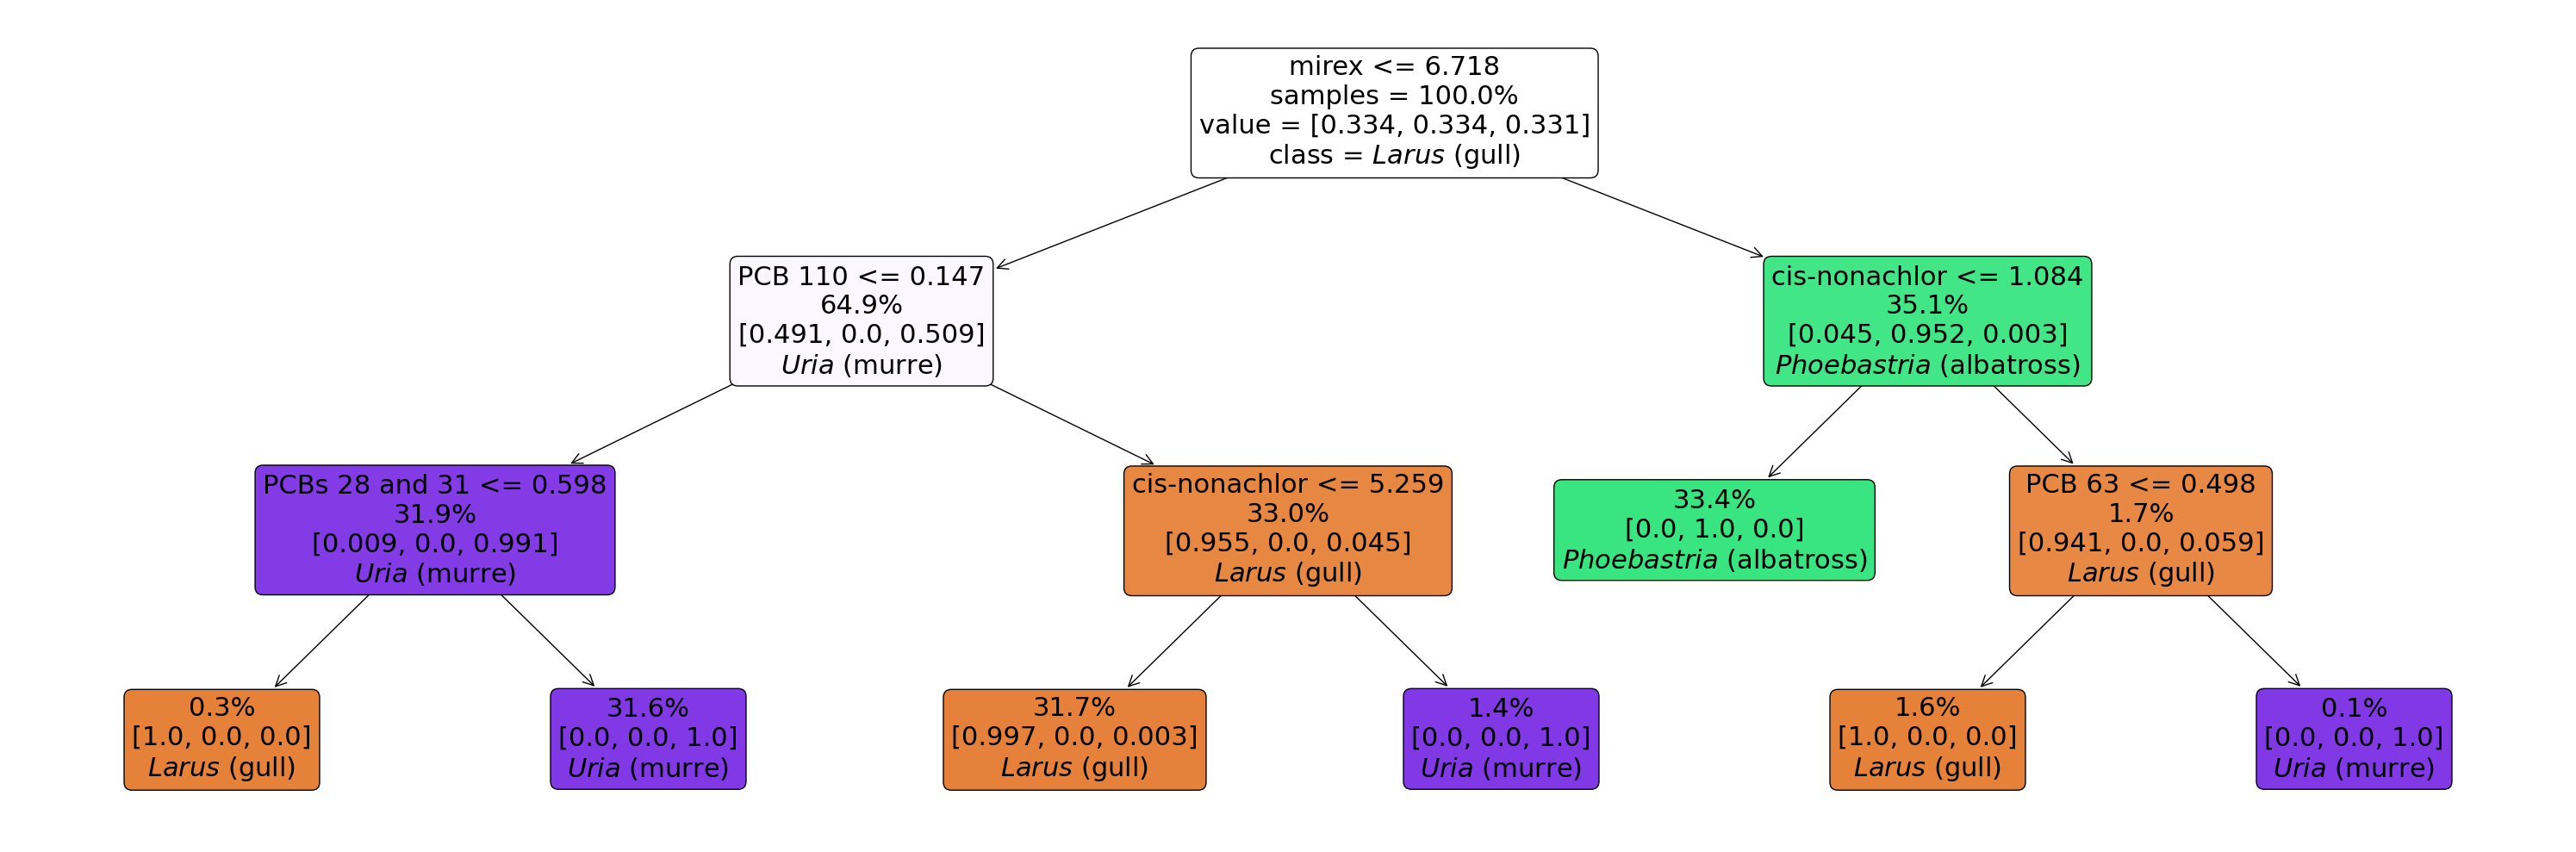

In [69]:
tree = gs.best_estimator_.named_steps['tree']

fig = plt.figure(figsize=(30,10))
_ = plot_tree(tree, feature_names=X.columns.tolist(),
             class_names=tree.classes_.tolist(), label='root',
             filled=True, proportion=True, impurity=False, ax=fig.gca(), fontsize=22, rounded=True)
plt.tight_layout()

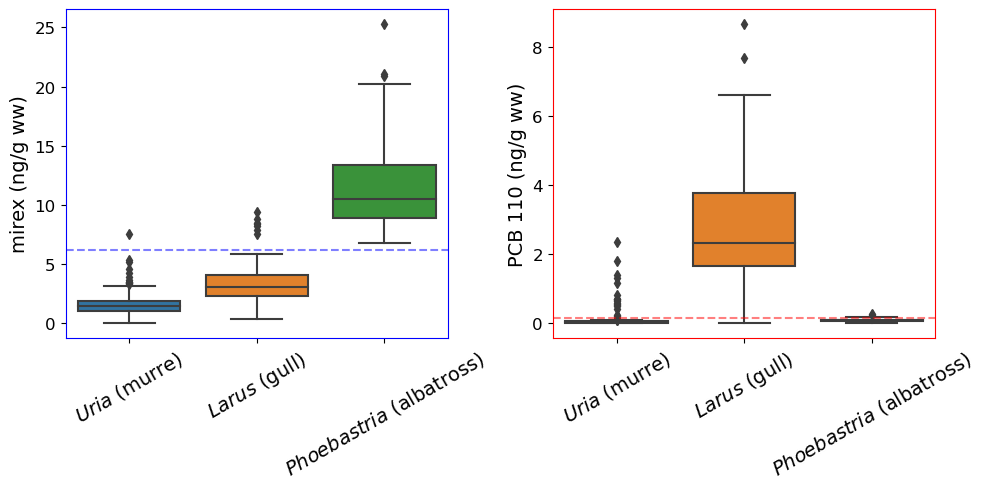

In [70]:
# Mirex and PCB 110 are predominantly resposible for splitting the data into the 3 genera

X_net = X.copy()
X_net['genus'] = y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for i,((a,l,c),ax) in enumerate(zip(
    [('mirex', 6.178, 'b'), ('PCB 110', 0.147, 'r')],
    axes.ravel()
)):
    ax_ = sns.boxplot(x='genus', y=a, data=X_net, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=tick_size)
    ax.tick_params(axis='y', which='major', labelsize=tick_size)
    ax.spines["top"].set_color(c)
    ax.spines["bottom"].set_color(c)
    ax.spines["left"].set_color(c)
    ax.spines["right"].set_color(c)
    ax.axhline(l, color=c, alpha=0.5, linestyle='--')
    _ = ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30, fontsize=label_size)
    _ = ax_.set_ylabel(a+' (ng/g ww)', fontsize=label_size)
    _ = ax.set_xlabel('')
plt.tight_layout()